In [1]:
# Libraries:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from toolbox.auxiliary_functions import SRT_simulation, D_CODE_simulation, set_param_freq

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


#### Case $n$, $k$, $k_a$ and $k_y$ fixed
Consider the modified Van der Pol system with a nonlinear forcing term
$$
\begin{cases}
\dot{x} = \frac{k y^n}{k_a + y^n} \\
\dot{y} = - k_y y
\end{cases}
$$
and with $n=2.8$, $k=1$, $k_a=4$ and $k_y=0.1$ fixed.

In [2]:
# Select ODE & settings:
ode_name = 'HillODE' # help="name of the ode", type=str
ode_param = '2.8,1,4,0.1' # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_ratio = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 102 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 0
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [3]:
# running SR-T:
building_blocks_lambda0, function_names0 = SRT_simulation(ode_name, ode_param, 0, freq, n_sample, noise_ratio, alg='tv', seed=seed, n_seed=n_seed, T=T)
building_blocks_lambda1, function_names1 = SRT_simulation(ode_name, ode_param, 1, freq, n_sample, noise_ratio, alg='tv', seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=HillODE, ode_param=[2.8, 1.0, 4.0, 0.1], x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=102, n_seed=1
Dataset shape:  (151, 50, 2)
Functions set:  {'neg': 1, 'mul': 1, 'pow': 1, 'add': 1, 'div': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.81      4.37599e+14        7         0.145326          0.16985      5.65m


/home/mattg/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)
/home/mattg/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   1     8.87           259797        7        0.0925208        0.0932065      4.63m
   2     4.03           230918        7        0.0923551         0.094698      4.17m
   3     5.35          76241.7       17        0.0456204        0.0462912      4.64m
   4     6.27          10957.6        9        0.0403082        0.0406541      3.90m
   5     6.64          20896.2        9         0.032913        0.0336438      3.42m
   6     6.93          44737.8        9        0.0258217        0.0262891      3.06m
   7     7.08          25398.6       11        0.0143359         0.014553      2.81m
   8     7.17          20921.6       11        0.0143244        0.0146561      2.23m
   9     7.20          16113.5       11        0.0143498        0.0144281      2.00m
  10     7.07          14751.2        9        0.0188364        0.0192488      1.83m
  11     7.57          11321.3        9        0.0186945        0.0179945      1.63m
  12     8.45          9822.03        9       0.00922951       0.

In [3]:
from scipy.integrate import solve_ivp
import numpy as np

class SRModel:
    def __init__(self, f):
        self.f = f  # la funzione dinamica, es. f = lambda z,t: [z[1], -np.sin(z[0])]
    
    def simulate(self, x0, t, u=None):
        # u ignorato, lo metti solo per compatibilità con SINDy
        sol = solve_ivp(lambda t, z: self.f(z, t), [t[0], t[-1]], x0, t_eval=t, vectorized=False)
        return sol.y.T  # restituisce shape (len(t), dim_x)
    
f = lambda x, t: [x[1]/(3.4858794923492793*x[1]**(-1.6696091361846237) + x[1]), 
                  -0.10047452707078909 * x[1]]
model = SRModel(f)


In [4]:
import numpy as np
import matplotlib.pyplot as plt


def evaluate_traj(model, ode, freq, n_sample, init_high, init_low,
                  dim_x=1, dim_k=1, title=None, T_aux=100):

    # =======================
    # STYLE
    # =======================
    plt.rcdefaults()

    np.random.seed(666)
    dt = 1 / freq
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # =======================
    # TRUE TRAJECTORIES
    # =======================
    dg_true = data.DataGenerator(
        ode, T_aux, freq, n_sample,
        noise_sigma=0.,
        init_high=init_high,
        init_low=init_low
    )
    xt_true = dg_true.xt

    # =======================
    # ESTIMATED TRAJECTORIES
    # =======================
    pred_0_list = []

    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        test_params = np.tile(correct_param, (T_plot, 1))

        if dim_k != 0:
            pred_0 = model.simulate(
                xt_true[0, i, :-dim_k],
                t=t,
                u=test_params
            )
        else:
            pred_0 = model.simulate(
                xt_true[0, i],
                t=t
            )

        pred_0_list.append(pred_0)

    # =======================
    # RESHAPE
    # =======================
    xt_true = xt_true[:len(pred_0), :, :]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]

    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2)).squeeze()

    time_vector = t[:len(pred_0_list)]

    # =======================
    # PLOTTING
    # =======================
    if n_sample == 1:

        # ---------- dim_x = 1 ----------
        if dim_x == 1:

            fig, ax = plt.subplots(1, 1, figsize=(5, 4))

            ax.plot(time_vector, pred_0_list,
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(time_vector, xt_true,
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            # Start / End
            ax.scatter(time_vector[0], xt_true[0],
                       s=30, color='green', zorder=3,
                       label='Start')

            ax.scatter(time_vector[-1], xt_true[-1],
                       s=30, color='red', zorder=3,
                       label='End')

            ax.set_xlabel("t")
            ax.set_ylabel("$x(t)$")

            ax.grid(True, alpha=0.3)

            if title:
                ax.set_title(title)

            ax.legend(fontsize=9, frameon=False, loc='lower right')
            plt.tight_layout()
            plt.show()

        # ---------- dim_x = 2 ----------
        elif dim_x == 2:

            fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

            # x(t)
            axes[0].plot(time_vector, pred_0_list[:, 0],
                         lw=1.5, color='blue', alpha=0.8,
                         label='Estimated $x(t)$')

            axes[0].plot(time_vector, xt_true[:, 0],
                         lw=1.5, color='red', linestyle='--',
                         label='True $x(t)$')

            axes[0].scatter(time_vector[0], xt_true[0, 0],
                            s=30, color='green', zorder=3,
                            label='Start')

            axes[0].scatter(time_vector[-1], xt_true[-1, 0],
                            s=30, color='red', zorder=3,
                            label='End')

            axes[0].set_ylabel("$x(t)$")
            axes[0].grid(True, alpha=0.3)
            axes[0].legend(fontsize=9, frameon=False)

            # y(t)
            axes[1].plot(time_vector, pred_0_list[:, 1],
                         lw=1.5, color='blue', alpha=0.8,
                         label='Estimated $y(t)$')

            axes[1].plot(time_vector, xt_true[:, 1],
                         lw=1.5, color='red', linestyle='--',
                         label='True $y(t)$')

            axes[1].scatter(time_vector[0], xt_true[0, 1],
                            s=30, color='green', zorder=3,
                            label='Start')

            axes[1].scatter(time_vector[-1], xt_true[-1, 1],
                            s=30, color='red', zorder=3,
                            label='End')

            axes[1].set_xlabel("t")
            axes[1].set_ylabel("$y(t)$")
            axes[1].grid(True, alpha=0.3)
            axes[1].legend(fontsize=9, frameon=False)

            if title:
                fig.suptitle(title)

            plt.tight_layout()
            plt.show()

        # ---------- dim_x >= 3 ----------
        else:

            fig, ax = plt.subplots(
                figsize=(6, 6),
                subplot_kw={'projection': '3d'}
            )

            ax.plot(pred_0_list[:, 0],
                    pred_0_list[:, 1],
                    pred_0_list[:, 2],
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(xt_true[:, 0],
                    xt_true[:, 1],
                    xt_true[:, 2],
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(xt_true[0, 0], xt_true[0, 1], xt_true[0, 2],
                       s=30, color='green', label='Start')

            ax.scatter(xt_true[-1, 0], xt_true[-1, 1], xt_true[-1, 2],
                       s=30, color='red', label='End')

            ax.set_xlabel("$x$")
            ax.set_ylabel("$y$")
            ax.set_zlabel("$z$")

            if title:
                ax.set_title(title)

            ax.legend(fontsize=9, frameon=False)
            plt.tight_layout()
            plt.show()


SR_T Model RMSE:  0.06840271811599817


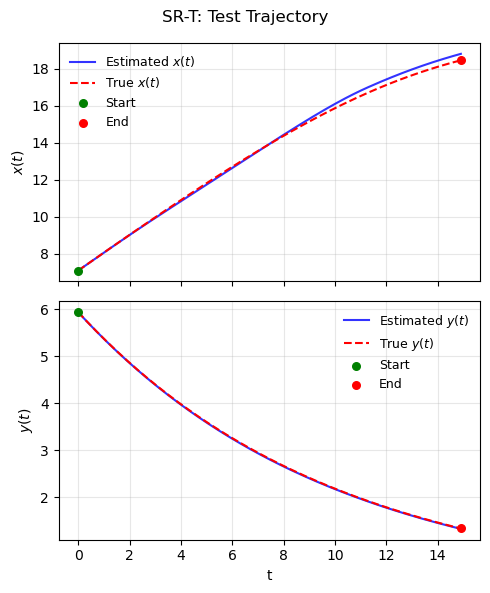

In [5]:
n_test = 10
rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_test, [10., 10.], [0., 0.], dim_k)
print('SR_T Model RMSE: ', rmse)

evaluate_sample = 1
ics = [7., 6.]
title = 'SR-T: Test Trajectory'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

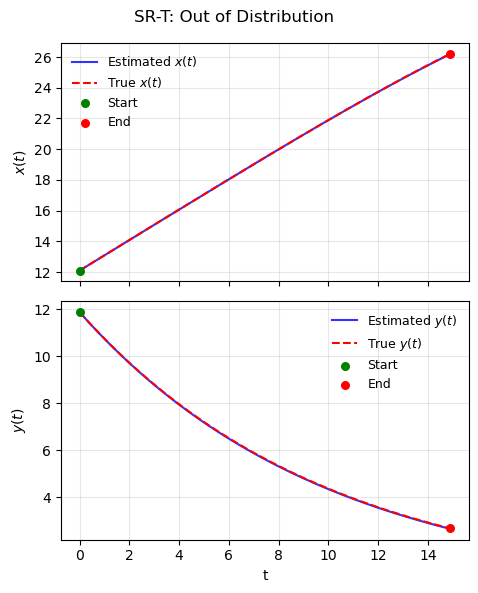

In [6]:
evaluate_sample = 1
ics = [12, 12]
title = 'SR-T: Out of Distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

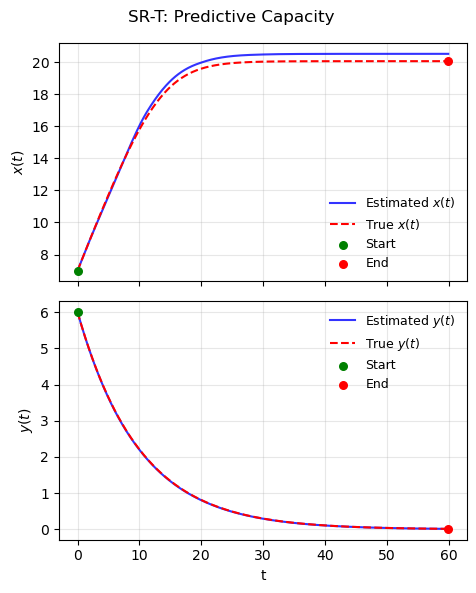

In [7]:
evaluate_sample = 1
ics = [7, 6]
title = 'SR-T: Predictive Capacity'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=60)

In [11]:
# running D-CODE
building_blocks_lambda0, function_names0 = D_CODE_simulation(ode_name, ode_param, 0, freq, n_sample, noise_ratio, seed=seed, n_seed=n_seed, T=T)
building_blocks_lambda1, function_names1 = D_CODE_simulation(ode_name, ode_param, 1, freq, n_sample, noise_ratio, seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=HillODE, ode_param=[2.8, 1.0, 4.0, 0.1], x_id=0, freq=10, n_sample=50, noise_sigma=0.01, seed=102, n_seed=1
Dataset shape:  (301, 50, 2)
Functions set:  {'neg': 1, 'mul': 1, 'pow': 1, 'add': 1, 'div': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    11.81      6.18395e+37       21          9.07699           8.3469      3.68m
   1     9.55      1.22138e+18        7          3.12836          2.97984      3.94m
   2     6.74      7.49518e+17        7          2.85531          5.43732      3.90m
 
promising programs:
div(div(div(mul(X1, X1), div(X0, X0)), add(div(2.037, X1), X1)), X1)
div(neg(neg(X1)), add(div(2.751, X1), X1))
div(add(pow(X1, 1.037), div(div(X1, X1), add(X0, X0))), add(X1, div(3.330, X1)))
div(div(div(mul(X1, X1), div(X0, X0)), add(div(3.008, X1

In [8]:
from scipy.integrate import solve_ivp
import numpy as np

class SRModel:
    def __init__(self, f):
        self.f = f  # la funzione dinamica, es. f = lambda z,t: [z[1], -np.sin(z[0])]
    
    def simulate(self, x0, t, u=None):
        # u ignorato, lo metti solo per compatibilità con SINDy
        sol = solve_ivp(lambda t, z: self.f(z, t), [t[0], t[-1]], x0, t_eval=t, vectorized=False)
        return sol.y.T  # restituisce shape (len(t), dim_x)
    
f = lambda x, t: [x[1]/(3.938724842182093*x[1]**(-1.7763694814000792) + x[1]), 
                  -0.099461821011630052 * x[1]]
model = SRModel(f)

In [9]:
import numpy as np
import matplotlib.pyplot as plt


def evaluate_traj(model, ode, freq, n_sample, init_high, init_low,
                  dim_x=1, dim_k=1, title=None, T_aux=100):

    # =======================
    # STYLE
    # =======================
    plt.rcdefaults()

    np.random.seed(666)
    dt = 1 / freq
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # =======================
    # TRUE TRAJECTORIES
    # =======================
    dg_true = data.DataGenerator(
        ode, T_aux, freq, n_sample,
        noise_sigma=0.,
        init_high=init_high,
        init_low=init_low
    )
    xt_true = dg_true.xt

    # =======================
    # ESTIMATED TRAJECTORIES
    # =======================
    pred_0_list = []

    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        test_params = np.tile(correct_param, (T_plot, 1))

        if dim_k != 0:
            pred_0 = model.simulate(
                xt_true[0, i, :-dim_k],
                t=t,
                u=test_params
            )
        else:
            pred_0 = model.simulate(
                xt_true[0, i],
                t=t
            )

        pred_0_list.append(pred_0)

    # =======================
    # RESHAPE
    # =======================
    xt_true = xt_true[:len(pred_0), :, :]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]

    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2)).squeeze()

    time_vector = t[:len(pred_0_list)]

    # =======================
    # PLOTTING
    # =======================
    if n_sample == 1:

        # ---------- dim_x = 1 ----------
        if dim_x == 1:

            fig, ax = plt.subplots(1, 1, figsize=(5, 4))

            ax.plot(time_vector, pred_0_list,
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(time_vector, xt_true,
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            # Start / End
            ax.scatter(time_vector[0], xt_true[0],
                       s=30, color='green', zorder=3,
                       label='Start')

            ax.scatter(time_vector[-1], xt_true[-1],
                       s=30, color='red', zorder=3,
                       label='End')

            ax.set_xlabel("t")
            ax.set_ylabel("$x(t)$")

            ax.grid(True, alpha=0.3)

            if title:
                ax.set_title(title)

            ax.legend(fontsize=9, frameon=False, loc='lower right')
            plt.tight_layout()
            plt.show()

        # ---------- dim_x = 2 ----------
        elif dim_x == 2:

            fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

            # x(t)
            axes[0].plot(time_vector, pred_0_list[:, 0],
                         lw=1.5, color='blue', alpha=0.8,
                         label='Estimated $x(t)$')

            axes[0].plot(time_vector, xt_true[:, 0],
                         lw=1.5, color='red', linestyle='--',
                         label='True $x(t)$')

            axes[0].scatter(time_vector[0], xt_true[0, 0],
                            s=30, color='green', zorder=3,
                            label='Start')

            axes[0].scatter(time_vector[-1], xt_true[-1, 0],
                            s=30, color='red', zorder=3,
                            label='End')

            axes[0].set_ylabel("$x(t)$")
            axes[0].grid(True, alpha=0.3)
            axes[0].legend(fontsize=9, frameon=False)

            # y(t)
            axes[1].plot(time_vector, pred_0_list[:, 1],
                         lw=1.5, color='blue', alpha=0.8,
                         label='Estimated $y(t)$')

            axes[1].plot(time_vector, xt_true[:, 1],
                         lw=1.5, color='red', linestyle='--',
                         label='True $y(t)$')

            axes[1].scatter(time_vector[0], xt_true[0, 1],
                            s=30, color='green', zorder=3,
                            label='Start')

            axes[1].scatter(time_vector[-1], xt_true[-1, 1],
                            s=30, color='red', zorder=3,
                            label='End')

            axes[1].set_xlabel("t")
            axes[1].set_ylabel("$y(t)$")
            axes[1].grid(True, alpha=0.3)
            axes[1].legend(fontsize=9, frameon=False)

            if title:
                fig.suptitle(title)

            plt.tight_layout()
            plt.show()

        # ---------- dim_x >= 3 ----------
        else:

            fig, ax = plt.subplots(
                figsize=(6, 6),
                subplot_kw={'projection': '3d'}
            )

            ax.plot(pred_0_list[:, 0],
                    pred_0_list[:, 1],
                    pred_0_list[:, 2],
                    lw=1.5, color='blue', alpha=0.8,
                    label='Estimated trajectory')

            ax.plot(xt_true[:, 0],
                    xt_true[:, 1],
                    xt_true[:, 2],
                    lw=1.5, color='red', linestyle='--',
                    label='True trajectory')

            ax.scatter(xt_true[0, 0], xt_true[0, 1], xt_true[0, 2],
                       s=30, color='green', label='Start')

            ax.scatter(xt_true[-1, 0], xt_true[-1, 1], xt_true[-1, 2],
                       s=30, color='red', label='End')

            ax.set_xlabel("$x$")
            ax.set_ylabel("$y$")
            ax.set_zlabel("$z$")

            if title:
                ax.set_title(title)

            ax.legend(fontsize=9, frameon=False)
            plt.tight_layout()
            plt.show()


D-CODE Model RMSE:  0.03705984521610342


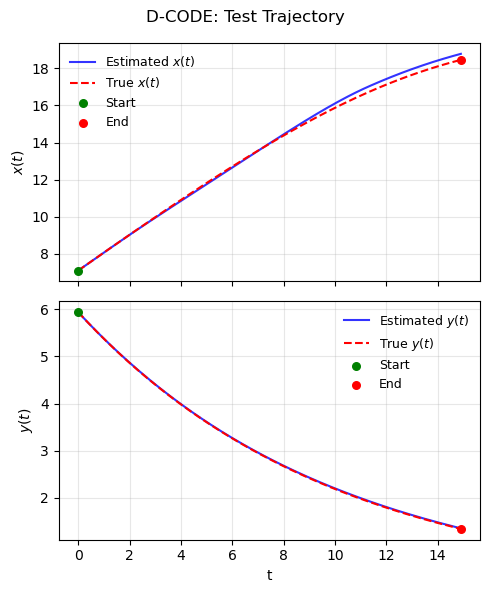

In [10]:
n_test = 10
rmse, _ = SINDy_data.evaluate_RMSE(model, ode, freq, n_test, [10., 10.], [0., 0.], dim_k)
print('D-CODE Model RMSE: ', rmse)

evaluate_sample = 1
ics = [7., 6.]
title = 'D-CODE: Test Trajectory'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

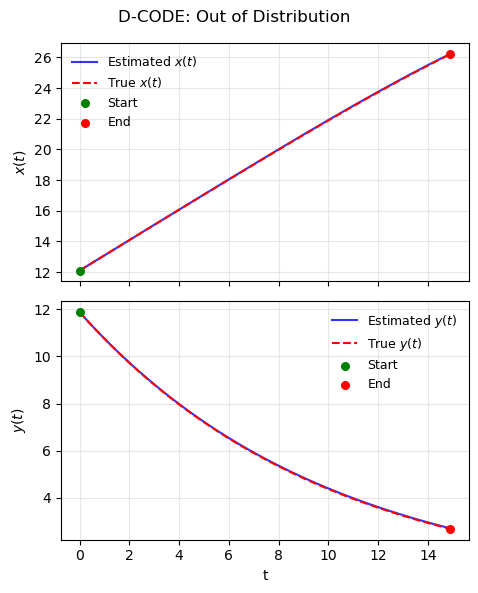

In [11]:
evaluate_sample = 1
ics = [12, 12]
title = 'D-CODE: Out of Distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

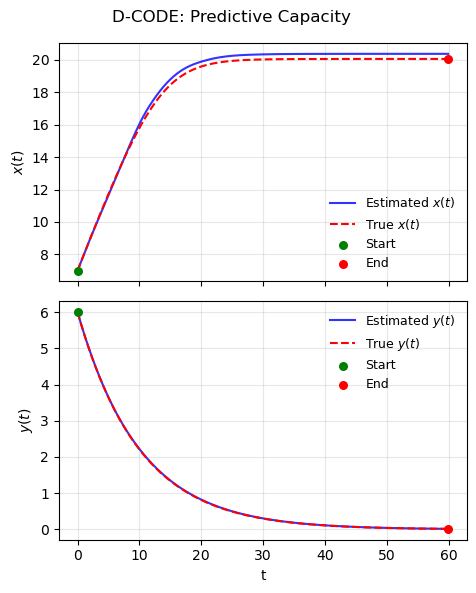

In [12]:
evaluate_sample = 1
ics = [7, 6]
title = 'D-CODE: Predictive Capacity'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=60)